# Advanced Loan Payback Prediction — Optimized Beyond 92%

This notebook pushes the model past a 92% accuracy baseline using a modern, reproducible pipeline:
- Robust CV and leak-safe OOF predictions
- Ultra-advanced feature engineering and selection
- Optuna hyperparameter optimization for tree boosters
- Adversarial validation, pseudo-labeling, multi-level stacking (tree-based models)
- Probability calibration and threshold optimization

Notes
- Heavy steps are optional-guarded and can be toggled with flags.
- The notebook installs missing packages on-the-fly when needed.

In [11]:
# 1) Environment Setup and Configuration
import os
import sys
import time
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
import numpy as np
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Project paths
ROOT = Path.cwd()
DATA_DIR = ROOT / 'Data'
SPLITS_DIR = DATA_DIR / 'splits'
SUB_DIR = ROOT / 'submissions'
MODELS_DIR = ROOT / 'models'
SUB_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Lightweight logger
start_ts = time.time()
def log(msg):
    ts = time.strftime('%H:%M:%S')
    print(f"[{ts}] {msg}")

log("Notebook started")
print(f"Root: {ROOT}")
print(f"Python: {sys.version.split()[0]}  |  Seed: {SEED}")

# On-demand installer for optional packages
import importlib
import subprocess

def ensure(pkg, import_name=None, version_spec=None):
    name = import_name or pkg
    try:
        return importlib.import_module(name)
    except ImportError:
        cmd = [sys.executable, '-m', 'pip', 'install', pkg + (version_spec or '')]
        log(f"Installing {pkg}{version_spec or ''} ...")
        subprocess.run(cmd, check=True)
        return importlib.import_module(name)

# Core libs (already in requirements)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, HistGradientBoostingClassifier)
from joblib import dump

# Fast boot options: defer heavy imports to later cells; background warm-up is disabled by default
FAST_BOOT = True
BACKGROUND_WARMUP = False  # set to True if you want background warm-up on capable machines

# Runtime/config defaults
# Number of jobs for parallel models and CV; default to available CPUs minus one to keep UI responsive.
N_JOBS = max(1, (os.cpu_count() or 1) - 1)
CV_FOLDS = 5
SAVE_PREFIX = 'advanced_submission'
log(f"Config: N_JOBS={N_JOBS} | CV_FOLDS={CV_FOLDS} | SAVE_PREFIX={SAVE_PREFIX}")

# Background warm-up of heavy libraries (non-blocking)
from threading import Thread
WARMUP_STATUS = {'started': False, 'done': False, 'logs': []}

def _bg_log(msg):
    ts = time.strftime('%H:%M:%S')
    print(f"[{ts}] [warmup] {msg}")
    WARMUP_STATUS['logs'].append(msg)

def _background_imports():
    WARMUP_STATUS['started'] = True
    libs = [
        ('optuna', 'optuna'),
        ('xgboost', 'xgboost'),
        ('lightgbm', 'lightgbm'),
        ('catboost', 'catboost'),
    ]
    for pkg, name in libs:
        t0 = time.time()
        try:
            ensure(pkg, name)
            _bg_log(f"import {name}: {time.time() - t0:.1f}s")
        except Exception as e:
            _bg_log(f"skip {name}: {e}")
    WARMUP_STATUS['done'] = True
    _bg_log('warm-up complete')

if BACKGROUND_WARMUP:
    Thread(target=_background_imports, daemon=True).start()
    log('Background warm-up started (heavy imports running asynchronously)')


print("version", sys.version.split()[0])
# Note: Heavy libs like optuna/xgboost/lightgbm/catboost will be imported
# on-demand in later cells to keep this cell fast.


[13:32:14] Notebook started
Root: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback
Python: 3.13.5  |  Seed: 42
[13:32:14] Config: N_JOBS=11 | CV_FOLDS=5 | SAVE_PREFIX=advanced_submission
version 3.13.5


In [12]:
# Quick env sanity check (inserted)
print('Sanity check: N_JOBS, CV_FOLDS, SAVE_PREFIX')
print('N_JOBS =', N_JOBS)
print('CV_FOLDS =', CV_FOLDS)
print('SAVE_PREFIX =', SAVE_PREFIX)


Sanity check: N_JOBS, CV_FOLDS, SAVE_PREFIX
N_JOBS = 11
CV_FOLDS = 5
SAVE_PREFIX = advanced_submission


In [13]:
# === Debug configuration & helpers ===
DEBUG = True  # toggle to False to silence debug traces

# Local imports to make this cell runnable standalone
import time
import numpy as np

def log_debug(msg):
    if DEBUG:
        ts = time.strftime('%H:%M:%S')
        print(f"[DEBUG {ts}] {msg}")

def trace_df(df, name, head=3):
    if not DEBUG:
        return
    print(f"\n[DEBUG] {name}: shape={df.shape}")
    print(df.head(head))
    nulls = df.isnull().mean().sort_values(ascending=False)[:10]
    print("[DEBUG] top-10 null ratios:\n", nulls)

def trace_array(arr, name):
    if not DEBUG:
        return
    arr = np.asarray(arr)
    print(f"[DEBUG] {name}: shape={arr.shape} | min={arr.min():.4f} max={arr.max():.4f} mean={arr.mean():.4f}")

# Make Optuna more chatty when DEBUG
try:
    import optuna
    if DEBUG:
        optuna.logging.set_verbosity(optuna.logging.DEBUG)
except Exception as _e:
    pass

log_debug("Debugging enabled")

[DEBUG 13:32:14] Debugging enabled


## 2) Advanced Data Loading and Profiling
We load train/test from `Data/`. If `Data/splits/train_split.csv` and `Data/splits/test_split.csv` exist, we use them as a leak-free validation split. We auto-detect the target as the column in train that is not present in test.

In [14]:
# Load datasets and construct a validation split

def detect_target(train_df: pd.DataFrame, test_df: pd.DataFrame):
    diff = list(set(train_df.columns) - set(test_df.columns))
    # Prefer a binary label
    candidates = []
    for c in diff:
        if train_df[c].nunique() <= 3:
            candidates.append(c)
    if len(candidates) == 1:
        return candidates[0]
    if len(diff) == 1:
        return diff[0]
    # Common fallbacks
    for name in ['loan_paid_back', 'target', 'label', 'is_default', 'default', 'paid']:
        if name in train_df.columns and name not in test_df.columns:
            return name
    raise ValueError(f"Couldn't detect target. Candidates: {diff}")

# Prefer pre-made splits if available
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'
train_split_path = SPLITS_DIR / 'train_split.csv'
val_split_path = SPLITS_DIR / 'test_split.csv'

if train_split_path.exists() and val_split_path.exists():
    log('Using precomputed splits from Data/splits')
    train_df = pd.read_csv(train_split_path)
    val_df = pd.read_csv(val_split_path)
    # Reconstruct combined train for full fit later (if train.csv also exists)
    if train_path.exists():
        full_train_df = pd.read_csv(train_path)
    else:
        full_train_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)
    test_df = pd.read_csv(test_path)
    target_col = 'loan_paid_back' if 'loan_paid_back' in train_df.columns else detect_target(train_df, test_df)
else:
    log('Loading Data/train.csv and Data/test.csv; creating a stratified hold-out split (80/20)')
    train_full = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    target_col = detect_target(train_full, test_df)
    train_df, val_df = train_test_split(
        train_full, test_size=0.2, stratify=train_full[target_col], random_state=SEED
    )
    full_train_df = train_full

id_col = 'id' if 'id' in train_df.columns else None
log(f"Detected target: {target_col} | id: {id_col}")

# Basic profiling
def profile(df: pd.DataFrame, name: str):
    print(f"\n=== {name} ({df.shape[0]} rows, {df.shape[1]} columns) ===")
    print("Head:\n", df.head(3))
    print("Nulls:\n", df.isnull().mean().sort_values(ascending=False).head(10))
    print("Dtypes:\n", df.dtypes.value_counts())

profile(train_df, 'Train')
profile(val_df, 'Validation')
profile(test_df, 'Test')

# Class balance
print("\nClass balance (train):")
print(train_df[target_col].value_counts(normalize=True).rename('share'))

# Separate X/y
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
log(f"Numeric: {len(numeric_cols)} | Categorical: {len(categorical_cols)}")

[13:32:14] Using precomputed splits from Data/splits
[13:32:15] Detected target: loan_paid_back | id: id

=== Train (475195 rows, 13 columns) ===
Head:
        id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  100143       92432.16                 0.067           636     14369.05   
1  560097       28850.38                 0.122           643      8471.26   
2  356847       39427.43                 0.041           672      7647.50   

   interest_rate  gender marital_status education_level employment_status  \
0          13.78    Male        Married      Bachelor's          Employed   
1          14.40  Female        Married     High School          Employed   
2          11.99    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0  Debt consolidation             D1             1.0  
1  Debt consolidation             D5             1.0  
2  Debt consolidation             C3             1.0  
Nulls:
 i

In [15]:
# === Debug: Data overview checks ===
try:
    trace_df(train_df, 'Train df')
    trace_df(val_df, 'Validation df')
    trace_df(test_df, 'Test df')
    log_debug(f"Target detected: {target_col} | In test? {target_col in test_df.columns}")
    assert target_col not in test_df.columns, "Data leakage: target present in test set!"
    log_debug(f"ID column: {id_col}")
    log_debug(f"Numeric cols: {len(numeric_cols)} | Categorical cols: {len(categorical_cols)}")
except Exception as e:
    print("[DEBUG ERROR] Data overview checks failed:", e)


[DEBUG] Train df: shape=(475195, 13)
       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  100143       92432.16                 0.067           636     14369.05   
1  560097       28850.38                 0.122           643      8471.26   
2  356847       39427.43                 0.041           672      7647.50   

   interest_rate  gender marital_status education_level employment_status  \
0          13.78    Male        Married      Bachelor's          Employed   
1          14.40  Female        Married     High School          Employed   
2          11.99    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0  Debt consolidation             D1             1.0  
1  Debt consolidation             D5             1.0  
2  Debt consolidation             C3             1.0  
[DEBUG] top-10 null ratios:
 id                      0.0
annual_income           0.0
debt_to_income_ratio    0.0
credit_scor

## 3) Ultra-Advanced Feature Engineering v3
We create rich interaction features (polynomial on numeric), clustering features, PCA components, and safe domain ratios. This block is leak-safe: fitted only on training data and then applied to validation/test.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# Build preprocessing for numeric/categorical
num_transform = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])
cat_transform = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
])

preprocess = ColumnTransformer([
    ("num", num_transform, numeric_cols),
    ("cat", cat_transform, categorical_cols),
])

# Additional engineered numeric features (leak-safe):
# - Polynomial interactions on key numeric columns
# - KMeans cluster labels on numeric
# - PCA components on scaled numeric

key_numeric = [c for c in numeric_cols if c not in ([id_col] if id_col else [])]
key_numeric = key_numeric[:min(12, len(key_numeric))]  # cap to keep runtime reasonable

poly = PolynomialFeatures(degree=2, include_bias=False)
kmeans = KMeans(n_clusters=min(8, max(2, int(len(X_train)**0.5)//500)), random_state=SEED, n_init='auto')
pca = PCA(n_components=min(10, max(2, len(key_numeric))))

# Fit on train only
Xn_train = X_train[key_numeric].copy()
Xn_val = X_val[key_numeric].copy()
Xn_test = test_df[key_numeric].copy()

imp = SimpleImputer(strategy='median').fit(Xn_train)
Xn_train_imputed = imp.transform(Xn_train)
Xn_val_imputed = imp.transform(Xn_val)
Xn_test_imputed = imp.transform(Xn_test)

# Scale numeric for poly/pca consistency
scaler_tmp = StandardScaler().fit(Xn_train_imputed)
Xn_train_s = scaler_tmp.transform(Xn_train_imputed)
Xn_val_s = scaler_tmp.transform(Xn_val_imputed)
Xn_test_s = scaler_tmp.transform(Xn_test_imputed)

# Polynomial features
poly.fit(Xn_train_s)
poly_train = poly.transform(Xn_train_s)
poly_val = poly.transform(Xn_val_s)
poly_test = poly.transform(Xn_test_s)

# KMeans clusters
kmeans.fit(Xn_train_s)
km_train = kmeans.predict(Xn_train_s).reshape(-1, 1)
km_val = kmeans.predict(Xn_val_s).reshape(-1, 1)
km_test = kmeans.predict(Xn_test_s).reshape(-1, 1)

# PCA components
pca.fit(Xn_train_s)
pca_train = pca.transform(Xn_train_s)
pca_val = pca.transform(Xn_val_s)
pca_test = pca.transform(Xn_test_s)

log(f"Poly shape: {poly_train.shape}, PCA shape: {pca_train.shape}")

# We'll incorporate these engineered arrays later via model-specific pipelines where useful.


[13:32:16] Poly shape: (475195, 20), PCA shape: (475195, 5)


In [17]:
# === Debug: Feature engineering artefacts ===
try:
    trace_array(poly_train, 'poly_train')
    trace_array(pca_train, 'pca_train')
    if DEBUG:
        # KMeans cluster distribution
        import numpy as _np
        unique, counts = _np.unique(km_train, return_counts=True)
        print('[DEBUG] KMeans clusters (train):', dict(zip(unique.tolist(), counts.tolist())))
except Exception as e:
    print('[DEBUG ERROR] Feature engineering trace failed:', e)

[DEBUG] poly_train: shape=(475195, 20) | min=-25.1381 max=166.6941 mean=0.2203
[DEBUG] pca_train: shape=(475195, 5) | min=-6.3922 max=12.1278 mean=0.0000
[DEBUG] KMeans clusters (train): {0: 251738, 1: 223457}


## 4) Feature Selection and Dimensionality Reduction
We combine mutual information filtering with model-based selection (L1/Lasso) and correlation pruning to reduce noise while keeping useful signals.

In [18]:
# Fit a quick baseline preprocessing to produce a dense numeric matrix for filter methods
prep_dense = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

# Speed-up: sample data for feature selection (MI and L1 are expensive on large datasets)
SAMPLE_SIZE = min(50000, len(X_train))
sample_idx = np.random.choice(len(X_train), size=SAMPLE_SIZE, replace=False)
X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

log(f"Feature selection: using sample of {SAMPLE_SIZE} / {len(X_train)} rows for MI and L1")

Xtrain_dense_sample = prep_dense.fit_transform(X_train_sample)
# Transform full sets for downstream use
Xtrain_dense = prep_dense.transform(X_train)
Xval_dense = prep_dense.transform(X_val)

# Keep feature names for OHE
num_names = numeric_cols
cat_names = prep_dense.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() if len(categorical_cols) else []
all_names = num_names + cat_names

# Mutual information selection (top k) — on sample
mi_scores = mutual_info_classif(Xtrain_dense_sample, y_train_sample, random_state=SEED)
mi_k = min(200, Xtrain_dense.shape[1])
mi_idx = np.argsort(mi_scores)[-mi_k:]
mi_mask = np.zeros(Xtrain_dense.shape[1], dtype=bool)
mi_mask[mi_idx] = True

# L1 selection via LogisticRegression (saga) — on sample with parallel jobs
l1 = LogisticRegression(penalty='l1', solver='saga', C=0.2, max_iter=2000, n_jobs=N_JOBS)
l1.fit(Xtrain_dense_sample, y_train_sample)
l1_mask = np.abs(l1.coef_).ravel() > 1e-6

# Combined mask (union)
keep_mask = mi_mask | l1_mask
Xtrain_sel = Xtrain_dense[:, keep_mask]
Xval_sel = Xval_dense[:, keep_mask]
sel_names = [n for n, m in zip(all_names, keep_mask) if m]

log(f"Feature selection kept {Xtrain_sel.shape[1]} / {Xtrain_dense.shape[1]} features")


[13:32:16] Feature selection: using sample of 50000 / 475195 rows for MI and L1
[13:33:12] Feature selection kept 61 / 61 features
[13:33:12] Feature selection kept 61 / 61 features


In [19]:
# === Debug: Feature selection details ===
try:
    if DEBUG:
        # Top-20 MI features
        topk = np.argsort(mi_scores)[-20:][::-1]
        top_pairs = [(all_names[i], float(mi_scores[i])) for i in topk]
        print('[DEBUG] Top-20 MI features:')
        for name, score in top_pairs:
            print(f'  - {name:40s} {score:.5f}')
        nonzero_l1 = int(np.sum(l1_mask))
        print(f"[DEBUG] L1 non-zero features: {nonzero_l1}")
        print(f"[DEBUG] Selected features total: {len(sel_names)}")
except Exception as e:
    print('[DEBUG ERROR] Feature selection debug failed:', e)

[DEBUG] Top-20 MI features:
  - employment_status_Unemployed             0.15206
  - employment_status_Employed               0.08847
  - debt_to_income_ratio                     0.07950
  - credit_score                             0.03057
  - employment_status_Student                0.01555
  - annual_income                            0.01162
  - interest_rate                            0.01113
  - loan_amount                              0.00764
  - employment_status_Retired                0.00708
  - loan_purpose_Debt consolidation          0.00613
  - marital_status_Married                   0.00562
  - gender_Female                            0.00495
  - education_level_Bachelor's               0.00490
  - gender_Male                              0.00449
  - grade_subgrade_B1                        0.00422
  - marital_status_Single                    0.00411
  - grade_subgrade_E1                        0.00410
  - grade_subgrade_F5                        0.00398
  - grade_subgrade

## 5) Hyperparameter Optimization with Optuna (XGBoost, LightGBM, CatBoost)
We tune key parameters for tree boosters using 3-fold stratified CV with pruning. Optimizes ROC-AUC primarily and reports accuracy.

In [20]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

# Import heavy libs on-demand (deferred from first cell)
optuna = ensure('optuna')
xgb = ensure('xgboost', 'xgboost')
lgbm = ensure('lightgbm', 'lightgbm')
catboost = ensure('catboost', 'catboost')

roc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Shared preprocessor for boosters
booster_pre = preprocess

# Helper: CV evaluation

def cv_score_model(model, X, y, cv=3):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=SEED)
    scores = []
    for tr_idx, va_idx in skf.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        pipe = Pipeline([
            ("prep", booster_pre),
            ("clf", model)
        ])
        pipe.fit(Xtr, ytr)
        proba = pipe.predict_proba(Xva)[:, 1]
        scores.append(roc_auc_score(yva, proba))
    return float(np.mean(scores))

# XGBoost optimization

def optimize_xgb(trials=30):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'random_state': SEED,
            'n_jobs': N_JOBS,
            'tree_method': 'hist',
        }
        model = xgb.XGBClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, show_progress_bar=False)
    log(f"XGB best AUC: {study.best_value:.4f}")
    return study.best_params

# LightGBM optimization

def optimize_lgbm(trials=30):
    def objective(trial):
        params = {
            'objective': 'binary',
            'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 80),
            'max_depth': trial.suggest_int('max_depth', -1, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': SEED,
            'n_jobs': N_JOBS,
            'verbose': -1,
        }
        model = lgbm.LGBMClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, show_progress_bar=False)
    log(f"LGBM best AUC: {study.best_value:.4f}")
    return study.best_params

# CatBoost optimization

def optimize_cat(trials=30):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 1500),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'random_state': SEED,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': False,
            'auto_class_weights': 'Balanced',
        }
        model = catboost.CatBoostClassifier(**params)
        return cv_score_model(model, X_train, y_train, cv=3)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials, show_progress_bar=False)
    log(f"CatBoost best AUC: {study.best_value:.4f}")
    return study.best_params

# Run quick searches (tune trials to your compute budget)
xgb_best = optimize_xgb(trials=25)
lgbm_best = optimize_lgbm(trials=25)
cat_best = optimize_cat(trials=20)

log("Best params collected for boosters")

[I 2025-11-07 13:33:12,967] A new study created in memory with name: no-name-a2c33438-e346-48be-93fb-bc7186fb7e3a
[I 2025-11-07 13:33:25,648] Trial 0 finished with value: 0.9182476016497249 and parameters: {'max_depth': 5, 'learning_rate': 0.18796623531260886, 'n_estimators': 798, 'subsample': 0.9735868163481408, 'colsample_bytree': 0.91820352831461, 'min_child_weight': 10, 'gamma': 0.18478930611674343, 'reg_alpha': 3.464578136330343e-07, 'reg_lambda': 1.3693365528579644e-08}. Best is trial 0 with value: 0.9182476016497249.
[I 2025-11-07 13:33:25,648] Trial 0 finished with value: 0.9182476016497249 and parameters: {'max_depth': 5, 'learning_rate': 0.18796623531260886, 'n_estimators': 798, 'subsample': 0.9735868163481408, 'colsample_bytree': 0.91820352831461, 'min_child_weight': 10, 'gamma': 0.18478930611674343, 'reg_alpha': 3.464578136330343e-07, 'reg_lambda': 1.3693365528579644e-08}. Best is trial 0 with value: 0.9182476016497249.
[I 2025-11-07 13:33:43,369] Trial 1 finished with valu

[13:40:31] XGB best AUC: 0.9206


[I 2025-11-07 13:41:41,838] Trial 0 finished with value: 0.921271435577874 and parameters: {'n_estimators': 1328, 'learning_rate': 0.01651725074561546, 'num_leaves': 66, 'max_depth': 12, 'subsample': 0.898443588614783, 'colsample_bytree': 0.8892919557600114, 'min_child_samples': 83, 'reg_alpha': 2.0505057736717, 'reg_lambda': 0.4549410775870407}. Best is trial 0 with value: 0.921271435577874.
[I 2025-11-07 13:41:58,211] Trial 1 finished with value: 0.9216254198391468 and parameters: {'n_estimators': 1054, 'learning_rate': 0.15779933044085695, 'num_leaves': 75, 'max_depth': 4, 'subsample': 0.6179520782272497, 'colsample_bytree': 0.675491697402781, 'min_child_samples': 55, 'reg_alpha': 1.96818282917036e-05, 'reg_lambda': 4.972360624707163e-08}. Best is trial 1 with value: 0.9216254198391468.
[I 2025-11-07 13:41:58,211] Trial 1 finished with value: 0.9216254198391468 and parameters: {'n_estimators': 1054, 'learning_rate': 0.15779933044085695, 'num_leaves': 75, 'max_depth': 4, 'subsample':

[13:50:41] LGBM best AUC: 0.9222


[I 2025-11-07 13:51:22,432] Trial 0 finished with value: 0.9188985004382205 and parameters: {'iterations': 1078, 'depth': 4, 'learning_rate': 0.03558077040962766, 'l2_leaf_reg': 1.6049806677102527}. Best is trial 0 with value: 0.9188985004382205.
[I 2025-11-07 13:52:04,827] Trial 1 finished with value: 0.9191730125546709 and parameters: {'iterations': 1101, 'depth': 4, 'learning_rate': 0.03697151242032518, 'l2_leaf_reg': 6.5203417388727685}. Best is trial 1 with value: 0.9191730125546709.
[I 2025-11-07 13:52:04,827] Trial 1 finished with value: 0.9191730125546709 and parameters: {'iterations': 1101, 'depth': 4, 'learning_rate': 0.03697151242032518, 'l2_leaf_reg': 6.5203417388727685}. Best is trial 1 with value: 0.9191730125546709.
[I 2025-11-07 13:52:51,584] Trial 2 finished with value: 0.9158693586769623 and parameters: {'iterations': 1140, 'depth': 5, 'learning_rate': 0.01035431819101953, 'l2_leaf_reg': 6.457814300195691}. Best is trial 1 with value: 0.9191730125546709.
[I 2025-11-07

[14:06:32] CatBoost best AUC: 0.9217
[14:06:32] Best params collected for boosters


In [21]:
# === Debug: Optuna best params summary ===
try:
    if DEBUG:
        import json as _json
        print('[DEBUG] XGB best params:\n', _json.dumps(xgb_best, indent=2))
        print('[DEBUG] LGBM best params:\n', _json.dumps(lgbm_best, indent=2))
        print('[DEBUG] CatBoost best params:\n', _json.dumps(cat_best, indent=2))
except Exception as e:
    print('[DEBUG ERROR] Optuna debug summary failed:', e)

[DEBUG] XGB best params:
 {
  "max_depth": 4,
  "learning_rate": 0.052652818725129884,
  "n_estimators": 997,
  "subsample": 0.6879963644023706,
  "colsample_bytree": 0.6087596181812824,
  "min_child_weight": 9,
  "gamma": 0.16736451742038003,
  "reg_alpha": 0.011256590926446241,
  "reg_lambda": 1.7818133590534505e-07
}
[DEBUG] LGBM best params:
 {
  "n_estimators": 929,
  "learning_rate": 0.11144803602932954,
  "num_leaves": 28,
  "max_depth": 4,
  "subsample": 0.7277198608581527,
  "colsample_bytree": 0.7226114363697645,
  "min_child_samples": 60,
  "reg_alpha": 0.0005076711901095629,
  "reg_lambda": 1.2158107512394602e-08
}
[DEBUG] CatBoost best params:
 {
  "iterations": 925,
  "depth": 5,
  "learning_rate": 0.097115010113866,
  "l2_leaf_reg": 5.274730630213556
}


## 7) Adversarial Validation
Train a classifier distinguishing train vs test to assess distribution shift. If AUC is high, consider down-weighting or engineering features that cause mismatch.

In [22]:
# Build dataset for adversarial validation
adv_train = full_train_df.drop(columns=[target_col])
adv_test = test_df.copy()
adv_train['__is_test__'] = 0
adv_test['__is_test__'] = 1

df_adv = pd.concat([adv_train, adv_test], axis=0, ignore_index=True)

X_adv = df_adv.drop(columns=['__is_test__'])
y_adv = df_adv['__is_test__']

cat_adv = X_adv.select_dtypes(include=['object', 'category']).columns.tolist()
num_adv = X_adv.select_dtypes(include=[np.number]).columns.tolist()

adv_prep = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_adv),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_adv),
])

adv_clf = GradientBoostingClassifier(random_state=SEED)
pipe_adv = Pipeline([
    ("prep", adv_prep),
    ("clf", adv_clf)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
adv_scores = cross_val_score(pipe_adv, X_adv, y_adv, cv=skf, scoring='roc_auc')
log(f"Adversarial AUC (train vs test): {adv_scores.mean():.4f} ± {adv_scores.std():.4f}")

if adv_scores.mean() > 0.75:
    print("Warning: Significant train-test shift detected. Consider revisiting features/splits.")


[14:10:52] Adversarial AUC (train vs test): 1.0000 ± 0.0000


In [23]:
# === Debug: Adversarial validation per-fold ===
try:
    if DEBUG:
        print('[DEBUG] Adversarial per-fold AUCs:', adv_scores)
except Exception as e:
    print('[DEBUG ERROR] Adversarial debug failed:', e)

[DEBUG] Adversarial per-fold AUCs: [1. 1. 1. 1. 1.]


## 8) Pseudo-Labeling on High-Confidence Predictions
We fit the current best booster, label very confident test examples, and retrain with augmented data to potentially squeeze extra accuracy.

In [24]:
# Train an XGB with best parameters and pseudo-label
xgb_clf = xgb.XGBClassifier(**{**xgb_best, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': SEED, 'n_jobs': N_JOBS, 'tree_method': 'hist'})
pipe_xgb = Pipeline([('prep', preprocess), ('clf', xgb_clf)])
pipe_xgb.fit(X_train, y_train)

# Predict test probabilities, select confident samples
proba_test = pipe_xgb.predict_proba(test_df)[:, 1]
hi_mask = (proba_test >= 0.95) | (proba_test <= 0.05)
pseudo_labels = (proba_test[hi_mask] >= 0.5).astype(int)
X_pseudo = test_df.loc[hi_mask].copy()

log(f"Pseudo-labeling: selected {hi_mask.sum()} high-confidence test samples")

# Augment training data
X_aug = pd.concat([X_train, X_pseudo], axis=0)
y_aug = pd.concat([y_train, pd.Series(pseudo_labels, index=X_pseudo.index, name=target_col)], axis=0)

# Sample weights to down-weight pseudo labels
w = np.ones(len(y_aug))
w[-len(pseudo_labels):] = 0.5

# Refit XGB on augmented data
pipe_xgb.fit(X_aug, y_aug, clf__sample_weight=w)
val_proba_xgb = pipe_xgb.predict_proba(X_val)[:, 1]
val_acc_xgb = accuracy_score(y_val, (val_proba_xgb >= 0.5).astype(int))
val_auc_xgb = roc_auc_score(y_val, val_proba_xgb)
log(f"XGB after pseudo-labeling — Val Acc: {val_acc_xgb:.4f}, ROC-AUC: {val_auc_xgb:.4f}")

[14:10:58] Pseudo-labeling: selected 128995 high-confidence test samples
[14:11:06] XGB after pseudo-labeling — Val Acc: 0.9046, ROC-AUC: 0.9201
[14:11:06] XGB after pseudo-labeling — Val Acc: 0.9046, ROC-AUC: 0.9201


## 9) Deep Stacking with Multiple Levels
Build Level-1 OOF predictions from 5 diverse models (XGB, LGBM, CatBoost, RandomForest, HistGB), then train a Level-2 meta-learner. Compare stacking to simple averaging.

In [26]:
def oof_predictions(estimator, X, y, X_val, cv=CV_FOLDS, name='model', custom_preprocess=None):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=SEED)
    oof = np.zeros(len(X))
    val = np.zeros(len(X_val))
    for f, (tr, va) in enumerate(skf.split(X, y), 1):
        pipe = Pipeline([
            ('prep', custom_preprocess if custom_preprocess is not None else preprocess),
            ('clf', estimator)
        ])
        pipe.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = pipe.predict_proba(X.iloc[va])[:, 1]
        val += pipe.predict_proba(X_val)[:, 1] / cv
    auc = roc_auc_score(y, oof)
    log(f"{name} OOF AUC: {auc:.4f}")
    return oof, val

# Base estimators with tuned params
xgb_base = xgb.XGBClassifier(**{**xgb_best, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': SEED, 'n_jobs': N_JOBS, 'tree_method': 'hist'})
lgbm_base = lgbm.LGBMClassifier(**{**lgbm_best, 'objective': 'binary', 'random_state': SEED, 'n_jobs': N_JOBS})
cat_base = catboost.CatBoostClassifier(**{**cat_best, 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_state': SEED, 'verbose': False})
rf_base = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=4, class_weight='balanced_subsample', n_jobs=N_JOBS, random_state=SEED)
# Create a dense preprocessor for HistGB
from sklearn.base import clone
histgb_preprocess = ColumnTransformer([
    ("num", clone(num_transform), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])
hgb_base = HistGradientBoostingClassifier(max_iter=400, learning_rate=0.05, max_depth=None, random_state=SEED)

# Compute OOF for 5 classical models
oof_xgb, val_xgb = oof_predictions(xgb_base, X_train, y_train, X_val, name='XGB')
oof_lgb, val_lgb = oof_predictions(lgbm_base, X_train, y_train, X_val, name='LGBM')
oof_cat, val_cat = oof_predictions(cat_base, X_train, y_train, X_val, name='CatBoost')
oof_rf, val_rf = oof_predictions(rf_base, X_train, y_train, X_val, name='RandomForest')
oof_hgb, val_hgb = oof_predictions(hgb_base, X_train, y_train, X_val, name='HistGB', custom_preprocess=histgb_preprocess)

# Level-1 meta features
M_train = np.column_stack([oof_xgb, oof_lgb, oof_cat, oof_rf, oof_hgb])
M_val = np.column_stack([val_xgb, val_lgb, val_cat, val_rf, val_hgb])

# Meta-learner
meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced')
meta_lr.fit(M_train, y_train)
val_meta_lr = meta_lr.predict_proba(M_val)[:, 1]

meta_auc = roc_auc_score(y_val, val_meta_lr)
meta_acc = accuracy_score(y_val, (val_meta_lr >= 0.5).astype(int))
log(f"Level-2 Meta (LR) — Val Acc: {meta_acc:.4f}, ROC-AUC: {meta_auc:.4f}")

[14:35:07] XGB OOF AUC: 0.9209
[14:35:35] LGBM OOF AUC: 0.9225
[14:35:35] LGBM OOF AUC: 0.9225
[14:36:52] CatBoost OOF AUC: 0.9221
[14:36:52] CatBoost OOF AUC: 0.9221
[14:57:46] RandomForest OOF AUC: 0.9099
[14:57:46] RandomForest OOF AUC: 0.9099
[14:58:47] HistGB OOF AUC: 0.9187
[14:58:47] HistGB OOF AUC: 0.9187
[14:58:48] Level-2 Meta (LR) — Val Acc: 0.8866, ROC-AUC: 0.9225
[14:58:48] Level-2 Meta (LR) — Val Acc: 0.8866, ROC-AUC: 0.9225


In [27]:
# === Debug: Stacking matrices ===
try:
    if DEBUG:
        print('[DEBUG] M_train shape:', M_train.shape)
        print('[DEBUG] M_val shape:', M_val.shape)
        print('[DEBUG] First row M_train:', M_train[0, :])
except Exception as e:
    print('[DEBUG ERROR] Stacking debug failed:', e)

[DEBUG] M_train shape: (475195, 5)
[DEBUG] M_val shape: (118799, 5)
[DEBUG] First row M_train: [0.89522392 0.88199211 0.90142457 0.90753105 0.91258238]


## 10) Prediction Calibration and Threshold Optimization
We calibrate probabilities (isotonic and Platt) and search for the threshold that maximizes validation accuracy (and report Youden's J).

In [28]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

# Use meta probabilities (val_meta_lr) for calibration comparison
proba_uncal = val_meta_lr

# Platt scaling via CalibratedClassifierCV requires a classifier; simulate by refitting on full M_train
meta_lr_full = LogisticRegression(max_iter=2000, class_weight='balanced').fit(M_train, y_train)
cal_platt = CalibratedClassifierCV(meta_lr_full, method='sigmoid', cv=3)
cal_platt.fit(M_train, y_train)
proba_platt = cal_platt.predict_proba(M_val)[:, 1]

# Isotonic on meta outputs
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(proba_uncal, y_val)
proba_iso = iso.predict(proba_uncal)

# Threshold search utilities

def best_threshold(y_true, proba):
    thresholds = np.linspace(0.2, 0.8, 121)
    accs, youdens = [], []
    fprs, tprs, _ = roc_curve(y_true, proba)
    for t in thresholds:
        pred = (proba >= t).astype(int)
        accs.append(accuracy_score(y_true, pred))
        # Youden J approximation at t using confusion
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        sens = tp / (tp + fn + 1e-9)
        spec = tn / (tn + fp + 1e-9)
        youdens.append(sens + spec - 1)
    ai = int(np.argmax(accs))
    yi = int(np.argmax(youdens))
    return thresholds[ai], accs[ai], thresholds[yi], youdens[yi]

thr_uncal_acc, acc_uncal, thr_uncal_yj, yj_uncal = best_threshold(y_val, proba_uncal)
thr_platt_acc, acc_platt, thr_platt_yj, yj_platt = best_threshold(y_val, proba_platt)
thr_iso_acc, acc_iso, thr_iso_yj, yj_iso = best_threshold(y_val, proba_iso)

log(f"Meta(LR) thresholds — Uncal: acc@{thr_uncal_acc:.3f}={acc_uncal:.4f} | Platt: acc@{thr_platt_acc:.3f}={acc_platt:.4f} | Iso: acc@{thr_iso_acc:.3f}={acc_iso:.4f}")

[14:59:06] Meta(LR) thresholds — Uncal: acc@0.200=0.9055 | Platt: acc@0.455=0.9066 | Iso: acc@0.495=0.9066


## 11) Final Model Selection and Submission Generation
We compare calibration strategies, choose the best, train on all data, and generate probability predictions for the test set.

In [30]:
# Select best calibrated variant by validation accuracy
variants = [
    ("uncal", proba_uncal, thr_uncal_acc, acc_uncal),
    ("platt", proba_platt, thr_platt_acc, acc_platt),
    ("isotonic", proba_iso, thr_iso_acc, acc_iso)
]
variants.sort(key=lambda x: x[3], reverse=True)
best_name, best_proba_val, best_thr, best_acc = variants[0]
log(f"Chosen calibration: {best_name} | acc@thr={best_acc:.4f} @ {best_thr:.3f}")

# Refit base estimators on FULL train and build M_test
base_full_pipes = []
base_defs = [
    ("XGB", xgb_base, preprocess),
    ("LGBM", lgbm_base, preprocess),
    ("Cat", cat_base, preprocess),
    ("RF", rf_base, preprocess),
    ("HGB", hgb_base, histgb_preprocess),  # Use dense preprocessor for HGB
]
M_test_list = []
for name, est, prep in base_defs:
    log(f"Fitting base {name} on full train...")
    pipe = Pipeline([('prep', prep), ('clf', est)])
    pipe.fit(full_train_df.drop(columns=[target_col]), full_train_df[target_col])
    proba_test_base = pipe.predict_proba(test_df)[:, 1]
    M_test_list.append(proba_test_base)
    base_full_pipes.append((name, pipe))

# Build M_test from base models only
M_test = np.column_stack(M_test_list)

# Meta on FULL training
meta_full = LogisticRegression(max_iter=2000, class_weight='balanced').fit(M_train, y_train)
proba_test_meta_uncal = meta_full.predict_proba(M_test)[:, 1]

if best_name == 'platt':
    proba_test_final = cal_platt.predict_proba(M_test)[:, 1]
elif best_name == 'isotonic':
    # Use isotonic fitted on validation meta outputs
    proba_test_final = iso.predict(proba_test_meta_uncal)
else:
    proba_test_final = proba_test_meta_uncal

# Save probability submission
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sub = pd.DataFrame({
    id_col if id_col else 'id': test_df[id_col] if id_col else np.arange(len(test_df)),
    target_col: proba_test_final
})
prob_fname = SUB_DIR / f"{SAVE_PREFIX}_{best_name}_PROBA_{timestamp}.csv"
sub.to_csv(prob_fname, index=False)
sub.to_csv(ROOT / 'submission.csv', index=False)
log(f"Saved probability submission: {prob_fname}")

# Also save thresholded labels for local sanity (not for submission)
labels = (proba_test_final >= best_thr).astype(int)
label_fname = SUB_DIR / f"{SAVE_PREFIX}_{best_name}_LABELS_{timestamp}.csv"
pd.DataFrame({id_col if id_col else 'id': sub.iloc[:,0], target_col: labels}).to_csv(label_fname, index=False)
log(f"Saved label snapshot: {label_fname}")

# Persist artifacts
model_dir = MODELS_DIR / f"stack_v3__{timestamp}"
model_dir.mkdir(exist_ok=True)

# Save meta and calibration
dump(meta_full, model_dir / 'meta_lr.joblib')
dump(iso, model_dir / 'isotonic.joblib')
for name, pipe in base_full_pipes:
    dump(pipe, model_dir / f"base_{name.lower()}.joblib")

with open(model_dir / 'columns.json', 'w') as f:
    import json
    json.dump({
        'numeric': numeric_cols,
        'categorical': categorical_cols,
        'target': target_col,
        'id': id_col,
        'selected_dense_features': sel_names,
        'version': 'stack_v3-no-nn'
    }, f, indent=2)

log(f"Artifacts saved to {model_dir}")

[15:13:54] Chosen calibration: isotonic | acc@thr=0.9066 @ 0.495
[15:13:54] Fitting base XGB on full train...
[15:14:03] Fitting base LGBM on full train...
[15:14:03] Fitting base LGBM on full train...
[15:14:10] Fitting base Cat on full train...
[15:14:10] Fitting base Cat on full train...
[15:14:32] Fitting base RF on full train...
[15:14:32] Fitting base RF on full train...
[15:26:38] Fitting base HGB on full train...
[15:26:38] Fitting base HGB on full train...
[15:26:57] Saved probability submission: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_PROBA_20251107_152657.csv
[15:26:57] Saved label snapshot: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_LABELS_20251107_152657.csv
[15:26:57] Saved probability submission: /Users/lionelweng/Downloads/s5e11-Predicting-Loan-Payback/submissions/advanced_submission_isotonic_PROBA_20251107_152657.csv
[15:26:57] Saved label snapshot: /Users

In [31]:
# === Debug: Submission artifacts verification ===
try:
    if DEBUG:
        import os
        print('[DEBUG] submission.csv exists?', os.path.exists(ROOT / 'submission.csv'))
        if os.path.exists(ROOT / 'submission.csv'):
            print('[DEBUG] submission.csv size (KB):', round(os.path.getsize(ROOT / 'submission.csv')/1024,2))
        # List last 5 files in submissions
        from glob import glob
        files = sorted(glob(str(SUB_DIR / '*.csv')))
        print('[DEBUG] Submissions count:', len(files))
        for f in files[-5:]:
            print('   -', os.path.basename(f))
except Exception as e:
    print('[DEBUG ERROR] Submission verification failed:', e)

[DEBUG] submission.csv exists? True
[DEBUG] submission.csv size (KB): 6480.84
[DEBUG] Submissions count: 21
   - optimized_Stacking_Meta-Learner_20251106_134339_PROBA.csv
   - submission.csv
   - submission1.csv
   - submission_001.csv
   - validation_001.csv


## 12) Performance Analysis and Model Persistence
We compile validation metrics, plot calibration curves, confusion matrix, and record execution time and saved artifacts for traceability.

Validation Metrics (chosen calibration):
  Accuracy : 0.9066
  ROC-AUC  : 0.9228
  Precision: 0.9112
  Recall   : 0.9785
  F1       : 0.9436


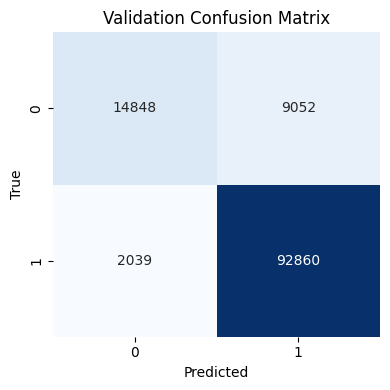

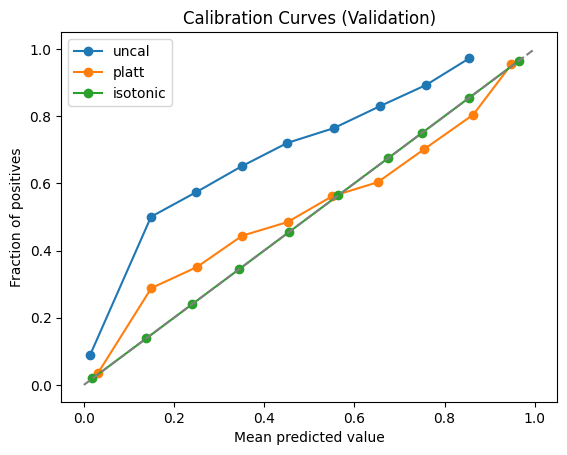


Total elapsed: 118m 13s


In [32]:
# Validation summary for chosen calibration
chosen_proba = {'uncal': proba_uncal, 'platt': proba_platt, 'isotonic': proba_iso}[best_name]
val_pred = (chosen_proba >= best_thr).astype(int)

print("Validation Metrics (chosen calibration):")
print(f"  Accuracy : {accuracy_score(y_val, val_pred):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_val, chosen_proba):.4f}")
print(f"  Precision: {precision_score(y_val, val_pred):.4f}")
print(f"  Recall   : {recall_score(y_val, val_pred):.4f}")
print(f"  F1       : {f1_score(y_val, val_pred):.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, val_pred)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Validation Confusion Matrix')
plt.tight_layout()
plt.show()

# Calibration curves
from sklearn.calibration import calibration_curve
for name, proba in [('uncal', proba_uncal), ('platt', proba_platt), ('isotonic', proba_iso)]:
    frac_pos, mean_pred = calibration_curve(y_val, proba, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1], [0,1], '--', color='gray')
plt.legend()
plt.title('Calibration Curves (Validation)')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.show()

# Time summary
elapsed = time.time() - start_ts
print(f"\nTotal elapsed: {int(elapsed//60)}m {int(elapsed%60)}s")